In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import bernoulli
from scipy.stats import beta
%matplotlib inline

# Background: Split Testing vs. Multi-Armed Bandits

Split testing and multi-armed bandits are alternative ways to manage online experiments. The main difference lies in how they handle the tradeoff between exploration and exploitation. 

In a split test the exploration/exploitation tradeoff is managed by a single factor determined at the start of the experiment: the sample size. By contrast, multi-armed bandits are designed to dynamically adjust the level of exploration in a way that maximizes long-term rewards. 

### Why does this difference matter? 

Simply put, it's hard to determine the optimal sample size. In scientific settings people commonly use power calculations, but statistical power is a tricky concept. Moreover, power calculations require an estimate of the expected effect size (i.e. the difference between treatment arms) and this is hard to estimate before you've actually run the experiment. It would be better to have a method the observes the results as they come in and adjusts the level of experimentation based on the data. This is exactly what multi-armed bandits do. 


### Multi-Armed Bandits in the Wild

Multi-armed bandits are used in a variety of ways by major tech companies. Google analytics uses them to manage their 'content experiments': https://support.google.com/analytics/answer/2844870?hl=en. 

# Common Split Testing Mistakes

Two of the most common mistakes in split testing are directly related to mismanaging the exploration/exploitation tradeoff: 

#### 1. Not running a test for long enough / sample size is too low

#### 2. Running a test for too long / sample size is too large


In this section I take a closer look at these pitfalls, with the aim of illustrating two key points:

- These costs are not negligible. In many realistic scenarios they are large enough to have a real business impact. 

- These costs can be largely avoided by employing smarter testing algorithms, namely multi-armed bandits. 

In [2]:
# Split test functions
def split_test(p1, p2, n_per_arm):
    
    arm_1_results = []
    arm_2_results = []
    for i in range(n_per_arm):
        
        x_1 = bernoulli.rvs(p1)
        x_2 = bernoulli.rvs(p2)
        
        arm_1_results.append(x_1)
        arm_2_results.append(x_2)
    
    total_rewards_1 = sum(arm_1_results)
    total_rewards_2 = sum(arm_2_results)
    
    rewards_dict = {'arm_1': total_rewards_1, 'arm_2': total_rewards_2}
    
    if total_rewards_1 > total_rewards_2:
        return({'winner': 'arm_1', 'rewards': rewards_dict})
    elif total_rewards_2 > total_rewards_1:
        return({'winner': 'arm_2', 'rewards': rewards_dict})
    else:
        return({'winner': 'tie', 'rewards': rewards_dict})
    
                
def split_test_sim(p1, p2, n_per_arm, n_sims):
    
    winner_list = []
    for i in range(n_sims):
        winner = split_test(p1, p2, n_per_arm)['winner']
        winner_list.append(winner)
    
    winner_series = pd.Series(winner_list)
    results_tab = winner_series.value_counts()
    
    return results_tab

def split_test_and_play(p1, p2, test_rounds, post_test_rounds):
    
    n_per_arm = int(np.floor(test_rounds / 2))
    test_results = split_test(p1, p2, n_per_arm)
    
    if test_results['winner'] == 'tie':
        toss = bernoulli.rvs(.5)
        if toss == 1:
            winner = 'arm_1'
            p = p1
        else:
            winner = 'arm_2'
            p = p2
    elif test_results['winner'] == 'arm_1':
        winner = 'arm_1'
        p = p1
    else:
        winner = 'arm_2'
        p = p2
    
    total_rewards = test_results['rewards']['arm_1'] + test_results['rewards']['arm_2']
    
    total_rewards += sum(bernoulli.rvs(p, size=post_test_rounds))
    
    return total_rewards
        

In [3]:
# MAB functions
def thompson_sim(p1, p2, rounds):
    
    A_rewards = 0
    B_rewards = 0
    
    A_sends = 0
    B_sends = 0
    
    alpha_A = 1
    alpha_B = 1

    beta_A = 1
    beta_B = 1
    
    total_rewards = 0
    for i in range(1, rounds + 1):
    
        # Select Arm
        draw_A = beta.rvs(alpha_A, beta_A)
        draw_B = beta.rvs(alpha_B, beta_B)
        
        winner = max([draw_A, draw_B])
        
        # pick winner
        if winner == draw_A:
            prob = p1
            r = bernoulli.rvs(prob)
            alpha_A += r
            beta_A += 1 - r
        elif winner == draw_B:
            prob = p2
            r = bernoulli.rvs(prob)
            alpha_B += r
            beta_B += 1 - r
        
        total_rewards += r
    
    return total_rewards

def epsilon_decreasing(p1, p2, test_rounds, post_test_rounds, epsilon):
    
    n_per_arm = int(np.floor(test_rounds / 2))
    test_results = split_test(p1, p2, n_per_arm)
    
    if test_results['winner'] == 'tie':
        toss = bernoulli.rvs(.5)
        if toss == 1:
            winner = 'arm_1'
            loser = 'arm_2'
        else:
            winner = 'arm_2'
            loser = 'arm_1'
    elif test_results['winner'] == 'arm_1':
        winner = 'arm_1'
        loser = 'arm_2'
    else:
        winner = 'arm_2'
        loser = 'arm_1'
    
    p_dict = {'arm_1': p1, 'arm_2': p2}
    reward_dict = {'arm_1': test_results['rewards']['arm_1'] / n_per_arm, 
                   'arm_2': test_results['rewards']['arm_2'] / n_per_arm}
    send_dict = {'arm_1': n_per_arm, 'arm_2': n_per_arm}
    
    for i in range(post_test_rounds):
        
        if i % 200 == 0:
            epsilon *= .9
            
        experiment = bernoulli.rvs(epsilon)
        
        if experiment == 1:
        
            r = bernoulli.rvs(p_dict[loser])
            reward_dict[loser] = (reward_dict[loser] * send_dict[loser] + r) / (send_dict[loser] + 1)
            send_dict[loser] += 1
        else:
            r = bernoulli.rvs(p_dict[winner])
            reward_dict[winner] = (reward_dict[winner] * send_dict[winner] + r) / (send_dict[winner] + 1)
            send_dict[winner] += 1
        
        winner = max(reward_dict)
    
    total_rewards = reward_dict['arm_1']*send_dict['arm_1'] + reward_dict['arm_2']*send_dict['arm_2']
    
    return (total_rewards)

### First pitfall: not running a test for long enough

Imagine we want to test two subject lines, one with a true open rate of 25% and the other with a true open rate of 30%. If we test each version on 50 contacts (100 total), how frequently will the worse option win? How about 100 contacts each? Or 150? 

What we find is that the worse arm wins more often than most people think. With 50 contacts in each arm, the worse option wins about 25% of the time. With 100 contacts the number falls to about 19% and with 150 contacts about 15%. 

In [4]:
p1 = .25
p2 = .3

n_50 = split_test_sim(p1, p2, n_per_arm=50, n_sims=10000) / 10000
n_100 = split_test_sim(p1, p2, n_per_arm=100, n_sims=10000) / 10000
n_150 = split_test_sim(p1, p2, n_per_arm=150, n_sims=10000) / 10000


In [5]:
df = pd.DataFrame({'50_Per_Arm': n_50, '100_Per_Arm': n_100, '150_Per_Arm': n_150})
df = df[['50_Per_Arm', '100_Per_Arm', '150_Per_Arm']]


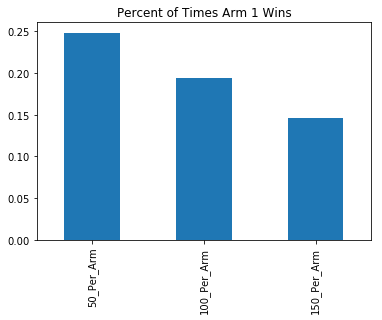

In [6]:
df.loc['arm_1'].plot(kind='bar', title="Percent of Times Arm 1 Wins");

It is worth noting that the default setting for an automation split test is 'split for 300 contacts (150 per arm)', so none of these scenarios are far fetched. 

### What are the long term consequences of choosing the wrong arm?

The impact of choosing the wrong arm may not seem that bad. After all, 25% is not that much lower than 30%. The problem is that the impact increases indefinitely, for as long as we continue sending the wrong email. If we only send 100 emails after the experiment, we only lose 5 opens. But if we send 5000 we lose 250. 

To illustrate this point we repeat the scenario above for a 300 contact split test but also assume the winner is sent to an additional 4700 people (5000 emails in total). 

In [7]:
p1 = .25
p2 = .3
test_rounds = 300 
post_test_rounds = 5000 - test_rounds

split_test_results = []
thompson_results = []
epsilon_results = []

for i in range(1000):
    sp_rewards = split_test_and_play(p1, p2, test_rounds, post_test_rounds)
    mab_rewards = thompson_sim(p1, p2, test_rounds + post_test_rounds)
    epsilon_rewards = epsilon_decreasing(p1, p2, test_rounds, post_test_rounds, epsilon=.1)
    
    split_test_results.append(sp_rewards)
    thompson_results.append(mab_rewards)
    epsilon_results.append(epsilon_rewards)
    
    if i % 100 == 0:
        print(i)

0
100
200
300
400
500
600
700
800
900


In [8]:
open_df = pd.DataFrame({'split test': split_test_results, 
                        'thompson sampling': thompson_results,
                        'epsilon decreasing': epsilon_results})

open_df.aggregate(['mean', 'median'])

,epsilon decreasing,split test,thompson sampling
mean,1485.981,1451.61,1479.101
median,1485.000,1485.00,1481.500


Although split-testing results in ~30 fewer opens ON AVERAGE, the medians are roughly the same. What's going on? 

Looking at the distribution of total rewards for each method helps us see the true picture. 

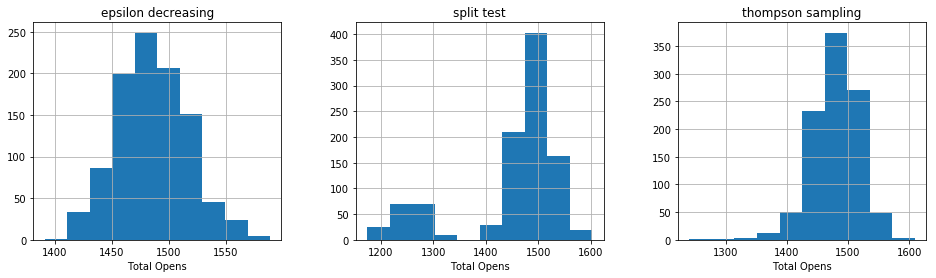

In [9]:
h = open_df.hist(layout=(1, 3), figsize=(16, 4));

for i in range(3):
    h[0][i].set_xlabel('Total Opens');

The split test results are bi-modal. About 85% of the time split testing does just as well as either multi-armed bandit, but 15% of the time it does far worse, resulting in around 250 fewer opens. 

### 2.  Running a test for too long

Here we look at the opposite problem--running a test for too long. 

In [10]:
p1 = .25
p2 = .3

split_test_results = []
thompson_results = []
epsilon_results = []

for i in range(1000):
    sp_rewards = split_test_and_play(p1, p2, 2000, 3000)
    thompson_rewards = thompson_sim(p1, p2, 5000)
    epsilon_rewards = epsilon_decreasing(p1, p2, 300, 4700, epsilon=.1)
    
    split_test_results.append(sp_rewards)
    thompson_results.append(thompson_rewards)
    epsilon_results.append(epsilon_rewards)
    
    if i % 100 == 0:
        print(i)  

0
100
200
300
400
500
600
700
800
900


In [11]:
click_df = pd.DataFrame({'split test': split_test_results, 
                         'thompson sampling': thompson_results,
                         'epsilon decreasing': epsilon_results})

click_df.aggregate(['mean', 'median'])

,epsilon decreasing,split test,thompson sampling
mean,1483.38,1449.083,1476.621
median,1483.00,1450.000,1479.000


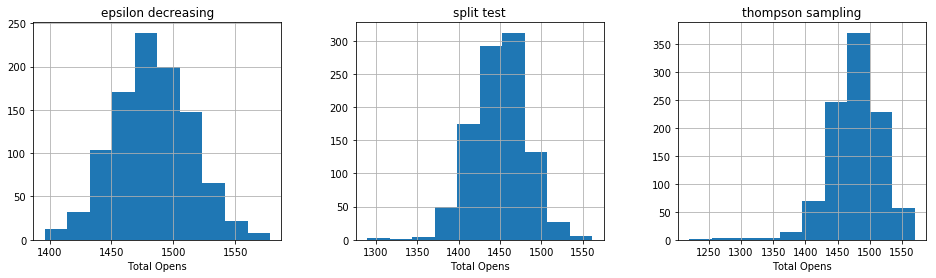

In [12]:
h2 = click_df.hist(layout=(1, 3), figsize=(16, 4));

for i in range(3):
    h2[0][i].set_xlabel('Total Opens');